# 3. Korean TrOCR Training on Amazon SageMaker
---

## Introduction
---

바로 이전 모듈에서 기존에 온프레미스에서 개발했던 환경과 동일한 환경으로 모델을 빌드하고 훈련했습니다. 하지만 아래와 같은 상황들에서도 기존 환경을 사용하는 것이 바람직할까요?

- 온프레미스의 GPU는 총 1장으로 훈련 시간이 너무 오래 소요됨
- 가용 서버 대수가 2대인데 10개의 딥러닝 모델을 동시에 훈련해야 함
- 필요한 상황에만 GPU를 활용
- 기타 등등

Amazon SageMaker는 데이터 과학자들 및 머신 러닝 엔지니어들을 위한 완전 관리형 머신 러닝 서비스로 훈련 및 추론 수행 시 인프라 설정에 대한 추가 작업이 필요하지 않기에, 단일 GPU 기반의 딥러닝 훈련을 포함한 멀티 GPU 및 멀티 인스턴스 분산 훈련을 보다 쉽고 빠르게 수행할 수 있습니다. SageMaker는 다양한 유즈케이스들에 적합한 예제들을 지속적으로 업데이트하고 있으며, 한국어 세션 및 자료들도 제공되고 있습니다.

### Notes

이미 기본적인 Hugging Face 용법 및 자연어 처리에 익숙하신 분들은 앞 모듈을 생략하고 이 모듈부터 핸즈온을 시작하셔도 됩니다.
이 노트북은 SageMaker 기본 API를 참조하므로, SageMaker Studio, SageMaker 노트북 인스턴스 또는 AWS CLI가 설정된 로컬 시스템에서 실행해야 합니다. SageMaker Studio 또는 SageMaker 노트북 인스턴스를 사용하는 경우 PyTorch 기반 커널을 선택하세요.
훈련 job 수행 시 최소 `ml.g4dn.xlarge` 이상의 훈련 인스턴스가 필요하며, `ml.g5.12xlarge` 인스턴스를 권장합니다. 만약 인스턴스 사용에 제한이 걸려 있다면 Request a service quota increase for SageMaker resources를 참조하여 인스턴스 제한을 해제해 주세요.


### References
- TrOCR GirHub: https://github.com/microsoft/unilm/tree/master/trocr
- Hugging Face TrOCR Tutorial: https://huggingface.co/docs/transformers/model_doc/trocr
- Hugging Face Stage-1 pre-trained model: https://huggingface.co/microsoft/trocr-base-stage1


## 1. Setup Environments
---

### Import modules

In [1]:
import boto3
import sagemaker
import sagemaker.huggingface

sess = sagemaker.Session()
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

role = sagemaker.get_execution_role()
region = boto3.Session().region_name
sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

In [2]:
import os
import sys
import json
import logging
import argparse
import torch
from torch import nn
import numpy as np
import pandas as pd
from tqdm import tqdm
from IPython.display import display, HTML

from transformers import (
    AutoTokenizer, VisionEncoderDecoderModel,
    Trainer, TrainingArguments, set_seed
)
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

from transformers.trainer_utils import get_last_checkpoint
from datasets import load_dataset, load_metric, ClassLabel, Sequence

logging.basicConfig(
    level=logging.INFO, 
    format='[{%(filename)s:%(lineno)d} %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(sys.stdout)
    ]
)
logger = logging.getLogger(__name__)

### Uploading data to Amazon S3 Bucket
SageMaker 훈련을 위해 데이터셋을 S3로 업로드합니다.

In [6]:
bucket = sess.default_bucket()

# s3 key prefix for the data
s3_prefix = 'samples/datasets/trocr'

train_local_path = 'train'

# save train_dataset to s3
train_input_path = f's3://{bucket}/{s3_prefix}/train'

In [7]:
%%time
!aws s3 cp {train_local_path} {train_input_path} --recursive --quiet

CPU times: user 34.5 ms, sys: 41.8 ms, total: 76.4 ms
Wall time: 5.68 s


<br>

## 2. Training with Native Hugging Face (PyTorch Framework)

---

### Overview and Training Script

SageMaker에 대한 대표적인 오해가 여전히 많은 분들이 SageMaker 훈련을 위해 소스 코드를 전면적으로 수정해야 한다고 생각합니다. 하지만, 실제로는 별도의 소스 코드 수정 없이 기존 여러분이 사용했던 파이썬 스크립트에 SageMaker 훈련에 필요한 SageMaker 전용 환경 변수들만 추가하면 됩니다. 

SageMaker 훈련은 훈련 작업을 호출할 때, 1) 훈련 EC2 인스턴스 프로비저닝 - 2) 컨테이너 구동을 위한 도커 이미지 및 훈련 데이터 다운로드 - 3) 컨테이너 구동 - 4) 컨테이너 환경에서 훈련 수행 - 5) 컨테이너 환경에서 S3의 특정 버킷에 저장 - 6) 훈련 인스턴스 종료로 구성됩니다. 따라서, 훈련 수행 로직은 아래 예시와 같이 기존 개발 환경과 동일합니다.

```python
/opt/conda/bin/python train.py --epochs 5 --train_batch_size 32 ...
```

이 과정에서 컨테이너 환경에 필요한 환경 변수(예: 모델 경로, 훈련 데이터 경로) 들은 사전에 지정되어 있으며, 이 환경 변수들이 설정되어 있어야 훈련에 필요한 파일들의 경로를 인식할 수 있습니다. 대표적인 환경 변수들에 대한 자세한 내용은 https://github.com/aws/sagemaker-containers#important-environment-variables 을 참조하세요.

In [15]:
from sagemaker.huggingface import HuggingFace
import time
instance_type = 'ml.g5.xlarge'
num_gpus = 1
instance_count = 1
batch_size = 16
learning_rate = 4e-5
logger.info(f'learning_rate: {learning_rate}')

# hyperparameters, which are passed into the training job
hyperparameters = {
    'n_gpus': num_gpus,                 # number of GPUs per instance
    'epochs': 1,                        # number of training epochs
    'seed': 42,                         # random seed
    'debug': True,                      # debug mode
    'fp16': True,                       # use FP16
    'disable_tqdm': True,               # disable tqdm?
    'train_batch_size': batch_size,     # batch size for training
    'eval_batch_size': batch_size,      # batch size for evaluation
    'learning_rate': learning_rate,     # learning rate used during training
}

[{4206700043.py:8} INFO - learning_rate: 4e-05


In [16]:
# define Training Job Name 
job_name = f'kornlp-trocr-training-{time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())}'
chkpt_s3_path = f's3://{bucket}/{s3_prefix}/native/checkpoints'

# create the Estimator
sm_estimator = HuggingFace(
    entry_point           = 'train.py',   # fine-tuning script used in training jon
    source_dir            = './scripts',        # directory where fine-tuning script is stored
    #instance_type         = 'local_gpu',
    instance_type         = instance_type,      # instances type used for the training job
    instance_count        = instance_count,     # the number of instances used for training
    base_job_name         = job_name,           # the name of the training job
    role                  = role,               # IAM role used in training job to access AWS ressources, e.g. S3
    transformers_version  = '4.17.0',           # the transformers version used in the training job
    pytorch_version       = '1.10.2',           # the pytorch_version version used in the training job
    py_version            = 'py38',             # the python version used in the training job
    hyperparameters       = hyperparameters,    # the hyperparameter used for running the training job
    disable_profiler      = True,
    debugger_hook_config  = False, 
    #checkpoint_s3_uri     = chkpt_s3_path,
    #checkpoint_local_path ='/opt/ml/checkpoints',  
)

logger.info(f'training job name: {job_name}')

[{3316609382.py:24} INFO - training job name: kornlp-trocr-training-2022-11-23-23-57-27


`fit()` 메소드를 호출하여 훈련 job을 시작합니다. `fit()` 메소드의 인자값 중 `wait=True`로 설정할 경우에는 동기(synchronous) 방식으로 동직하게 되며, `wait=False`일 경우에는 비동기(aynchronous) 방식으로 동작하여 여러 개의 훈련 job을 동시에 실행할 수 있습니다.

In [17]:
# define a data input dictonary with our uploaded s3 uris
data = {
    'train': train_input_path,
}

# starting the train job with our uploaded datasets as input
sm_estimator.fit(data, wait=False)
train_job_name = sm_estimator.latest_training_job.job_name

[{image_uris.py:599} INFO - image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
[{session.py:609} INFO - Creating training-job with name: kornlp-trocr-training-2022-11-23-23-57--2022-11-23-23-57-28-096


### View Training Job
SageMaker 콘솔 창에서 훈련 내역을 직접 확인할 수도 있지만, 아래 코드 셀에서 생성되는 링크를 클릭하면 더 편리하게 훈련 내역을 확인할 수 있습니다.

In [18]:
from IPython.core.display import display, HTML

def make_console_link(region, train_job_name, train_task='[Training]'):
    train_job_link = f' {train_task} Review {region}#/jobs/{train_job_name}">Training Job'   
    cloudwatch_link = f' {train_task} Review {region}#logStream:group=/aws/sagemaker/TrainingJobs;prefix={train_job_name};streamFilter=typeLogStreamPrefix">CloudWatch Logs'
    return train_job_link, cloudwatch_link  
        
train_job_link, cloudwatch_link = make_console_link(region, train_job_name, '[Hugging Face Training - Native]')

display(HTML(train_job_link))
display(HTML(cloudwatch_link))

### Wait for the training jobs to complete
훈련이 완료될 때까지 기다립니다. `estimator.fit(...)`에서 `wait=False`로 설정한 경우, 아래 코드 셀의 주석을 해제 후 실행하여 동기 방식으로 변경할 수도 있습니다. 훈련 완료까지는 약 15-20분의 시간이 소요됩니다.

In [19]:
#sess.logs_for_job(job_name=train_job_name, wait=True)

### Copy model artifacts from S3 to local path

훈련된 모델 파라메터는 `model.tar.gz`로 압축되어 S3에 저장됩니다. 만약 SageMaker 상에서 훈련한 모델을 곧바로 배포한다면, 아래 코드 셀을 실행할 필요는 없지만, 로컬/개발 환경에서 훈련된 모델을 간단히 테스트하거나 다른 환경에서 모델을 서빙할 때는 S3에 저장된 모델을 다운로드하셔야 합니다.

In [25]:
local_model_dir = './model'
!rm -rf {local_model_dir}
s3_model_path = sm_estimator.model_data
os.makedirs(local_model_dir, exist_ok=True)

In [26]:
%%bash -s "$local_model_dir" "$s3_model_path"
aws s3 cp $2 $1
cd $1
tar -xzvf model.tar.gz

download: s3://sagemaker-us-east-1-143656149352/kornlp-trocr-training-2022-11-23-23-57--2022-11-23-23-57-28-096/output/model.tar.gz to model/model.tar.gz
tokenizer_config.json
config.json
tokenizer.json
special_tokens_map.json
training_args.bin
pytorch_model.bin
vocab.txt


In [23]:
%store s3_model_path local_model_dir

Stored 's3_model_path' (str)
Stored 'local_model_dir' (str)


<br>

## Inference
---

SageMaker 훈련 인스턴스에서 훈련한 모델은 여러분의 유즈케이스에 맞게 자유롭게 사용할 수 있습니다. 

In [27]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, AutoTokenizer
import requests 
from PIL import Image

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten") 
model = VisionEncoderDecoderModel.from_pretrained(local_model_dir)
tokenizer = AutoTokenizer.from_pretrained(local_model_dir)

샘플 데이터로 자유롭게 추론을 수행해 보세요. 참고로, 샘플 데이터 중 랜덤한 문장은 검증셋에도 없는 신규 데이터입니다.

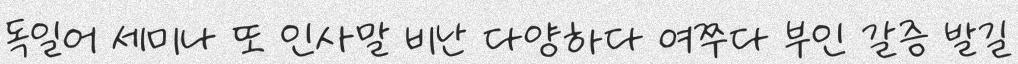

In [33]:
import glob
sample_img_paths = glob.glob('sample_imgs/*.jpg')
img_idx = np.random.randint(len(sample_img_paths))
image = Image.open(sample_img_paths[img_idx])
image

In [34]:
pixel_values = processor(image, return_tensors="pt").pixel_values 
generated_ids = model.generate(pixel_values, max_length=64)
generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0] 
print(generated_text)

독일어 세미나 또 인사말 비난 다양하다 여주다 부인 갈증 유발
